## Introduction 
In this notebook, I want to predict different arrhytmia on ECG using a LSTM with Pytorch.

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import json
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [15]:
def save_json(log, savepath):
    with open(os.path.join(savepath, "log.json"), "w") as f:
        json.dump(log, f, indent=4)

## Load ECG dataset

In [16]:

def load_ECG_dataset(path):
    csv_train_path = os.path.join(path, "mitbih_train.csv")
    csv_test_path  = os.path.join(path, "mitbih_test.csv")  
    csv_train_data = pd.read_csv(csv_train_path)
    csv_test_data = pd.read_csv(csv_test_path)

    train_x = np.array(csv_train_data.iloc[:, :187], dtype=np.float32).reshape(-1, 187, 1)
    train_y = np.array(csv_train_data.iloc[:, 187], dtype=np.int32)

    test_x = np.array(csv_test_data.iloc[:, :187], dtype=np.float32).reshape(-1, 187, 1)
    test_y = np.array(csv_test_data.iloc[:, 187], dtype=np.int32)

    Nonectopic_beat, Supraventricular_ectopic_beat, Ventricular_ectopic_beat, Fusion_beat, Unknown_beat = [], [], [], [], []
    for data, label in zip(train_x, train_y):
        if label == 0:
            Nonectopic_beat.append([data, label])
        elif label == 1:
            Supraventricular_ectopic_beat.append([data, label])
        elif label == 2:
            Ventricular_ectopic_beat.append([data, label])
        elif label == 3:
            Fusion_beat.append([data, label])
        elif label == 4:
            Unknown_beat.append([data, label])
    
    train_dataset_dict = {"N": Nonectopic_beat, "S":Supraventricular_ectopic_beat, 
                          "V": Ventricular_ectopic_beat, "F": Fusion_beat, "Q":Unknown_beat}
        
    print("---Training dataset---")
    print("Nonectopic beat               :", len(Nonectopic_beat))
    print("Supraventricular ectopic beat :", len(Supraventricular_ectopic_beat))
    print("Ventricular ectopic beat      :", len(Ventricular_ectopic_beat))
    print("Fusion beat                   :", len(Fusion_beat))
    print("Unknown beat                  :", len(Unknown_beat))
    print("----------------------")

  
    Nonectopic_beat, Supraventricular_ectopic_beat, Ventricular_ectopic_beat, Fusion_beat, Unknown_beat = [], [], [], [], []
    for data, label in zip(test_x, test_y):
        if label == 0:
            Nonectopic_beat.append([data, label])
        elif label == 1:
            Supraventricular_ectopic_beat.append([data, label])
        elif label == 2:
            Ventricular_ectopic_beat.append([data, label])
        elif label == 3:
            Fusion_beat.append([data, label])
        elif label == 4:
            Unknown_beat.append([data, label])
    
    test_dataset_dict = {"N": Nonectopic_beat, "S":Supraventricular_ectopic_beat, 
                          "V": Ventricular_ectopic_beat, "F": Fusion_beat, "Q":Unknown_beat}
    
    print("---Test dataset---")
    print("Nonectopic beat               :", len(Nonectopic_beat))
    print("Supraventricular ectopic beat :", len(Supraventricular_ectopic_beat))
    print("Ventricular ectopic beat      :", len(Ventricular_ectopic_beat))
    print("Fusion beat                   :", len(Fusion_beat))
    print("Unknown beat                  :", len(Unknown_beat))
    print("----------------------")
    
    return train_dataset_dict, test_dataset_dict

def split_dataset(train_dataset_dict, val_num, seed=0):   
    Nonectopic = train_dataset_dict["N"]
    Supraventricular = train_dataset_dict["S"]
    Ventricular = train_dataset_dict["V"]
    Fusion = train_dataset_dict["F"]
    Unknown = train_dataset_dict["Q"]
    
    train, validation = [], []

    np.random.seed(seed)
    np.random.shuffle(Nonectopic)
    np.random.shuffle(Supraventricular)
    np.random.shuffle(Ventricular)
    np.random.shuffle(Fusion)
    np.random.shuffle(Unknown)
    
    dataset_list = [Nonectopic, Supraventricular, Ventricular, Fusion, Unknown]
    for i, dataset in enumerate(dataset_list):
        for data, label in dataset[ : val_num]:
            validation.append([data, label])
            
        for data, label in dataset[val_num :]:
            train.append([data, label])
    
    print("train :", len(train))
    print("validation :", len(validation))
    
    return train, validation

In [17]:
path = "/kaggle/input/heartbeat"
train_dataset_dict, test_dataset_dict = load_ECG_dataset(path)
train_dataset, validation_dataset = split_dataset(train_dataset_dict, val_num=100, seed=0)

---Training dataset---
Nonectopic beat               : 72470
Supraventricular ectopic beat : 2223
Ventricular ectopic beat      : 5788
Fusion beat                   : 641
Unknown beat                  : 6431
----------------------
---Test dataset---
Nonectopic beat               : 18117
Supraventricular ectopic beat : 556
Ventricular ectopic beat      : 1448
Fusion beat                   : 162
Unknown beat                  : 1608
----------------------
train : 87053
validation : 500


## LSTM

In [18]:
#Model
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
    

## Train 

In [19]:
def train_model(model, dataloaders_dict, criterion, optimizer, scheduler, device, 
                num_epochs=25, early_stopping_epoch=10, savedirpath="result"):
    
    os.makedirs(savedirpath, exist_ok=True)
    
    since = time.time()    
    log_list = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_count = 0
    start_time = time.time()
    print('TRAINING starts')
    for epoch in range(num_epochs):
        epoch = epoch + 1
        print('-' * 70)
        print('epoch : {}'.format(epoch))
        
        epoch_result = {}
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_dict[phase]: 
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_time = time.time() - start_time
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = np.float64(running_corrects.double() / len(dataloaders_dict[phase].dataset))
           
            if phase == "train":
                print("train      loss: {:.4f}, accuracy : {:.4f}, elapsed time: {:.4f}"
                      .format(epoch_loss, epoch_acc, epoch_time))
            else:
                print("validation loss: {:.4f}, accuracy : {:.4f}, elapsed time: {:.4f}"
                      .format(epoch_loss, epoch_acc, epoch_time))
            
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                save_model_weight_path = os.path.join(savedirpath, "trained_model.pt") 
                torch.save(model.state_dict(), save_model_weight_path)
                
                early_stopping_count  = 0
            elif phase == "val" and epoch_acc <= best_acc:
                early_stopping_count += 1


            epoch_result["epoch"] = epoch
            epoch_result["elapsed_time"] = epoch_time
            if phase == "train":    
                epoch_result["train/loss"] = epoch_loss
                epoch_result["train/accuracy"] = epoch_acc
            
            else:
                epoch_result["validation/loss"] = epoch_loss
                epoch_result["validation/accuracy"] = epoch_acc
            
        log_list.append(epoch_result)
        save_json(log_list, savedirpath)
        #plot_learning_curve(savedirpath)
        
        #early stopping
        if early_stopping_count == early_stopping_epoch:
            print("Eearly stopping have been performed in this training")
            print("Epoch : {}".format(epoch))
            break
        
        
        
        
    time_elapsed = time.time() - since
    print("---------------------------------------------")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best epoch   : {}".format(best_epoch))
    print('Best validation Accuracy: {:4f}'.format(best_acc))
    print("---------------------------------------------")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [20]:
gpu = 0
num_epochs = 100
stopping_epoch = 20
learning_rate = 1.0

input_size = 1
hidden_size = 128
num_layers = 1
batch_size = 128

num_classes = 5
out = "./result"

In [21]:
train_dataloader = torch.utils.data.DataLoader(
                        train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
                        validation_dataset, batch_size=16, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
    
if gpu >= 0:
    device = torch.device("cuda:0".format(gpu))
else:
    device = torch.device("cpu")

In [22]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, device)
model = model.to(device) 

criterion = nn.CrossEntropyLoss().to(device)     
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate * 1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [23]:
 trained_model = train_model(model, dataloaders_dict, criterion, 
                           optimizer, exp_lr_scheduler, device,
                           num_epochs, stopping_epoch,
                           savedirpath=out)

TRAINING starts
----------------------------------------------------------------------
epoch : 1
train      loss: 0.6595, accuracy : 0.8313, elapsed time: 9.4122
validation loss: 2.7462, accuracy : 0.2000, elapsed time: 9.5137
----------------------------------------------------------------------
epoch : 2
train      loss: 0.6416, accuracy : 0.8315, elapsed time: 19.2980
validation loss: 2.7317, accuracy : 0.2000, elapsed time: 19.4264
----------------------------------------------------------------------
epoch : 3
train      loss: 0.6294, accuracy : 0.8312, elapsed time: 28.8623
validation loss: 2.4780, accuracy : 0.1960, elapsed time: 28.9636
----------------------------------------------------------------------
epoch : 4
train      loss: 0.6127, accuracy : 0.8263, elapsed time: 38.3386
validation loss: 2.7743, accuracy : 0.2060, elapsed time: 38.4405
----------------------------------------------------------------------
epoch : 5
train      loss: 0.6315, accuracy : 0.8321, elapsed t

train      loss: 0.0747, accuracy : 0.9792, elapsed time: 373.9107
validation loss: 0.5113, accuracy : 0.8600, elapsed time: 374.0250
----------------------------------------------------------------------
epoch : 40
train      loss: 0.0743, accuracy : 0.9789, elapsed time: 384.2149
validation loss: 0.6338, accuracy : 0.8120, elapsed time: 384.3231
----------------------------------------------------------------------
epoch : 41
train      loss: 0.0701, accuracy : 0.9805, elapsed time: 393.6530
validation loss: 0.5220, accuracy : 0.8660, elapsed time: 393.7527
----------------------------------------------------------------------
epoch : 42
train      loss: 0.0682, accuracy : 0.9805, elapsed time: 403.1084
validation loss: 0.5330, accuracy : 0.8480, elapsed time: 403.2122
----------------------------------------------------------------------
epoch : 43
train      loss: 0.0666, accuracy : 0.9814, elapsed time: 412.8519
validation loss: 0.5652, accuracy : 0.8480, elapsed time: 412.9553
--

train      loss: 0.0314, accuracy : 0.9904, elapsed time: 739.0079
validation loss: 0.4341, accuracy : 0.8940, elapsed time: 739.1085
----------------------------------------------------------------------
epoch : 78
train      loss: 0.0303, accuracy : 0.9904, elapsed time: 748.5352
validation loss: 0.4425, accuracy : 0.8920, elapsed time: 748.6330
----------------------------------------------------------------------
epoch : 79
train      loss: 0.0326, accuracy : 0.9896, elapsed time: 758.0297
validation loss: 0.4337, accuracy : 0.9040, elapsed time: 758.1322
----------------------------------------------------------------------
epoch : 80
train      loss: 0.0300, accuracy : 0.9906, elapsed time: 767.4452
validation loss: 0.5057, accuracy : 0.8580, elapsed time: 767.5521
----------------------------------------------------------------------
epoch : 81
train      loss: 0.0295, accuracy : 0.9910, elapsed time: 776.9965
validation loss: 0.4777, accuracy : 0.8800, elapsed time: 777.0986
--

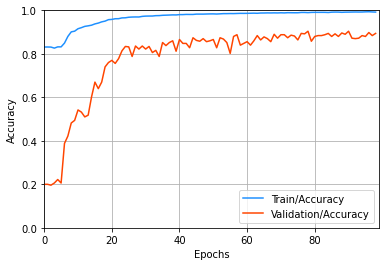

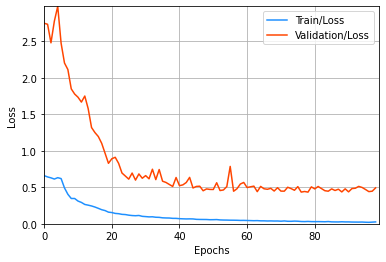

In [24]:
def load_json(filename):
    with open(filename) as f:
        log = json.load(f)
    f.close()
    return log

def plot_learning_curve(logdirpath):
    log = load_json(os.path.join(logdirpath, "log.json"))
    
    Epochs, TrainAccuracy, TrainLoss, ValidationAccuracy, ValidationLoss = [], [], [], [], []
    
    #for i in range(lne(log)):
    for i, data in enumerate(log):
        Epochs.append(data["epoch"])
        TrainAccuracy.append(data["train/accuracy"])
        TrainLoss.append(data["train/loss"])
        ValidationAccuracy.append(data["validation/accuracy"])
        ValidationLoss.append(data["validation/loss"])
        
    
    plt.figure()    
    plt.plot(TrainAccuracy, color='dodgerblue',  label='Train/Accuracy')
    plt.plot(ValidationAccuracy, color="orangered", label="Validation/Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    plt.xlim([0, len(Epochs)])
    plt.ylim([0, 1.0])
    plt.grid(True)
    plt.legend(loc= "lower right")
    
    accpath = os.path.join(logdirpath, "accuracy.svg")
    #plt.savefig(accpath)
    #plt.close()


    plt.figure()
    plt.plot(TrainLoss, color="dodgerblue", label="Train/Loss")
    plt.plot(ValidationLoss, color="orangered", label="Validation/Loss")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.xlim([0, len(Epochs)])
    plt.ylim([0, max(TrainLoss+ValidationLoss)])
    plt.grid(True)
    plt.legend(loc= "upper right")
    
    losspath = os.path.join(logdirpath, "loss.svg")
    #plt.savefig(losspath)
    #plt.close()
    
plot_learning_curve(out)

## Predict test dataset

In [25]:
trained_model.eval()
    
test_dataset = [[data, label]  for key in test_dataset_dict.keys() for data, label in test_dataset_dict[key] ]
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
label_mat = np.zeros((len(test_dataset), num_classes))
pred_score_mat = np.zeros_like(label_mat)
    
classification_result = []
confusion_matrix = np.zeros((num_classes, num_classes))

for i, (input_data, label) in enumerate(test_dataloader):
        
    input_data = input_data.to(device)
    label = label.to(device).long()
        
    output = F.softmax(trained_model(input_data), dim=1)
    pred_score_mat[i] = output.to("cpu").detach().numpy().copy()
    pred = int(torch.argmax(output.data))
        
    confusion_matrix[label][pred] += 1
    

Accuracy : 88.28[%]


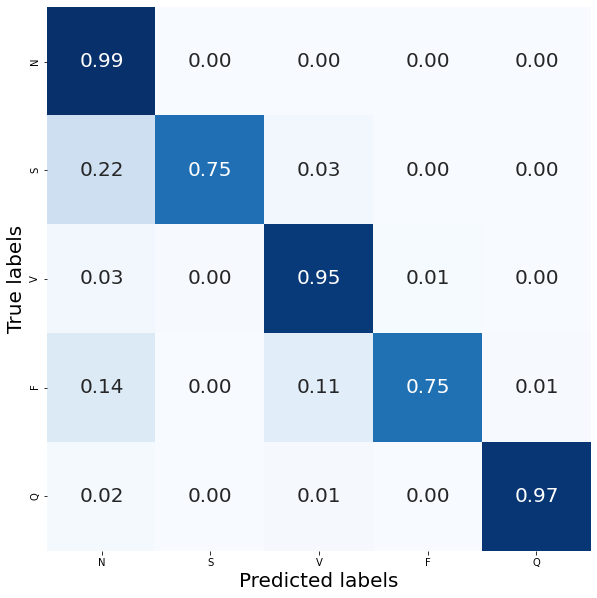

In [26]:
x_name = ["N", "S", "V", "F", "Q"]
y_name = ["N", "S", "V", "F", "Q"] 
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))   
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt=".2f", annot_kws={'size': 20},
                xticklabels=x_name, yticklabels=y_name, cbar=False, square=True)
plt.xlabel("Predicted labels", fontsize=20)
plt.ylabel("True labels", fontsize=20)
    
    
accuracy = sum(np.diag(confusion_matrix) / len(confusion_matrix)) * 100
print("Accuracy : {:.2f}[%]".format(accuracy))